# Task 2-2: Multi-body problem

Change the parameter OBJ to simulate multiple objects movement (2 <= OBJ <= 10)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch, time, sys
import numpy as np
import scipy.integrate, scipy.ndimage
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = '../experiment-body-3+'
sys.path.append(EXPERIMENT_DIR)

MODEL_DIR = '../src'
sys.path.append(MODEL_DIR)

from layers import MLP
from models import HNN, ModLaNet
from utils import L2_loss
from data import Dataset

In [2]:
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"]  = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
wordsize = 18
plt.rc('font', size=wordsize)          # controls default text sizes
plt.rc('axes', titlesize=wordsize)     # fontsize of the axes title
plt.rc('axes', labelsize=wordsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=wordsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=wordsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=wordsize)    # legend fontsize
plt.rc('figure', titlesize=wordsize)  # fontsize of the figure title

## Set some notebook constants

In [4]:
CUT = 0
DPI = 300
FORMAT = 'png'

def get_args():
    return {'obj': 4,
            'dof': 2,
            'dim': 2,
            'hidden_dim': 200,
            'trans_hidden_dim': 16,
            'trans_nonlinearity': 'tanh',
            'energy_hidden_dim': 50,
            'energy_nonlinearity': 'tanh',
            'learn_rate': 1e-3,
            'input_noise': 0.,
            'batch_size': 600,
            'nonlinearity': 'tanh',
            'total_steps': 1500,
            'field_type': 'solenoidal',
            'print_every': 200,
            'verbose': True,
            'name': 'body',
            'seed': 66,
            'save_dir': '{}'.format(EXPERIMENT_DIR+'/data'),
            'result_dir': '../results'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView(get_args())

## Construct models

In [5]:
def BuildComputationTree(transform = 'local', obj=3, dim=2, dof=2, device = 'cpu'):
    r"""
    User defined relations between elements and origins of local coordinate systems.
    We assume that these connections between origins and elements 
    can be obtained when local coordinate systems are constructed.

    Function: x_{i, origin} =   \sum_j x_{j, element} * weight_j + 
                                \sum_k x_{k, origin}  * weight_k + 
                                weight_c
    Form: [i, 
            [[j1, weight_j1], [j2, weight_j2], ...], 
            [[k1, weight_k1], [k2, weight_k2], ...], 
            weight_c]
    """
    tree = None
    if transform == 'local':
        ################################
        # User defined relations start #
        ################################
        pass
        ################################
        # User defined relations end   #
        ################################
    return tree

In [6]:
def get_model(args, model_name, end_epoch, noise, learn_rate, hidden_dim = None, load_obj = None):
    load_obj = args.obj if load_obj is None else load_obj
    hidden_dim = args.hidden_dim if hidden_dim is None else hidden_dim
    path = '{}/model-{}-{}-{}-hidden_dim-{}-end_epoch-{}-noise-{}-learn_rate-{}.tar'.format(args.save_dir, load_obj, args.name,
                                                                           model_name, hidden_dim, end_epoch,
                                                                           noise, learn_rate)
    checkpoint = torch.load(path)
    if model_name == 'modlanet':
        model = ModLaNet(obj=load_obj, dim=args.dim, edof=args.dof, build_computation_tree=BuildComputationTree, transform = 'global',
                         trans_hidden_dim = args.trans_hidden_dim, trans_nonlinearity = args.trans_nonlinearity, 
                         energy_hidden_dim = args.energy_hidden_dim, energy_nonlinearity=args.energy_nonlinearity)
        model.load_state_dict(checkpoint['network_state_dict'])
    else:
        assert load_obj == args.obj
        input_dim = args.obj * args.dof * 2
        output_dim = input_dim if model_name == 'baseline' else 2
        nn_model = MLP(input_dim, hidden_dim, output_dim, args.nonlinearity)
        model = HNN(input_dim, differentiable_model=nn_model,
                  field_type=args.field_type, baseline= (model_name == 'baseline') )

        model.load_state_dict(checkpoint['network_state_dict'])
    return model

In [7]:
def integrate_model(args, model, t_span, y0, model_name = 'modlanet', **kwargs):
    if model_name == 'modlanet':
        def fun(t, np_x):
            x = torch.tensor( np_x[:args.obj*args.dof], requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof)
            v = torch.tensor( np_x[args.obj*args.dof:], requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof)
            dx = model.forward(x, v).data.numpy().reshape(-1)
            return np.concatenate((np_x[args.obj*args.dof:], dx))
    else:
        def fun(t, np_x):
            x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof*2)
            dx = model.time_derivative(x).data.numpy().reshape(-1)
            return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [8]:
modlanet_model = get_model(args, model_name = 'modlanet', hidden_dim = 50, load_obj = 3, end_epoch = 3000, noise = 0., learn_rate = 0.001)
modlanet_model.update(obj = args.obj)

modlanet_model_retrain = get_model(args, model_name = 'modlanet', hidden_dim = 50, load_obj = 4, end_epoch = 4000, noise = 0., learn_rate = 0.001)
# modlanet_model_retrain.update(obj = args.obj)


## Visualize one example from dataset

In [9]:
args.obj = 4
modlanet_model.update(obj = args.obj)
np.random.seed(66)

In [10]:
ds = Dataset(args.obj, m = [1. for i in range(args.obj)])
y0 = ds.random_config()

t_span    = [0,30]
timescale = 10
tra1 = ds.get_trajectory(t_span = t_span, y0=y0, timescale = timescale, system='modlanet')

In [11]:
t_span = [0, 30]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], (t_span[1]-t_span[0])*timescale+1), 'rtol': 1e-12}

modlanet_ivp = integrate_model(args, modlanet_model, t_span, y0, model_name = 'modlanet', **kwargs)

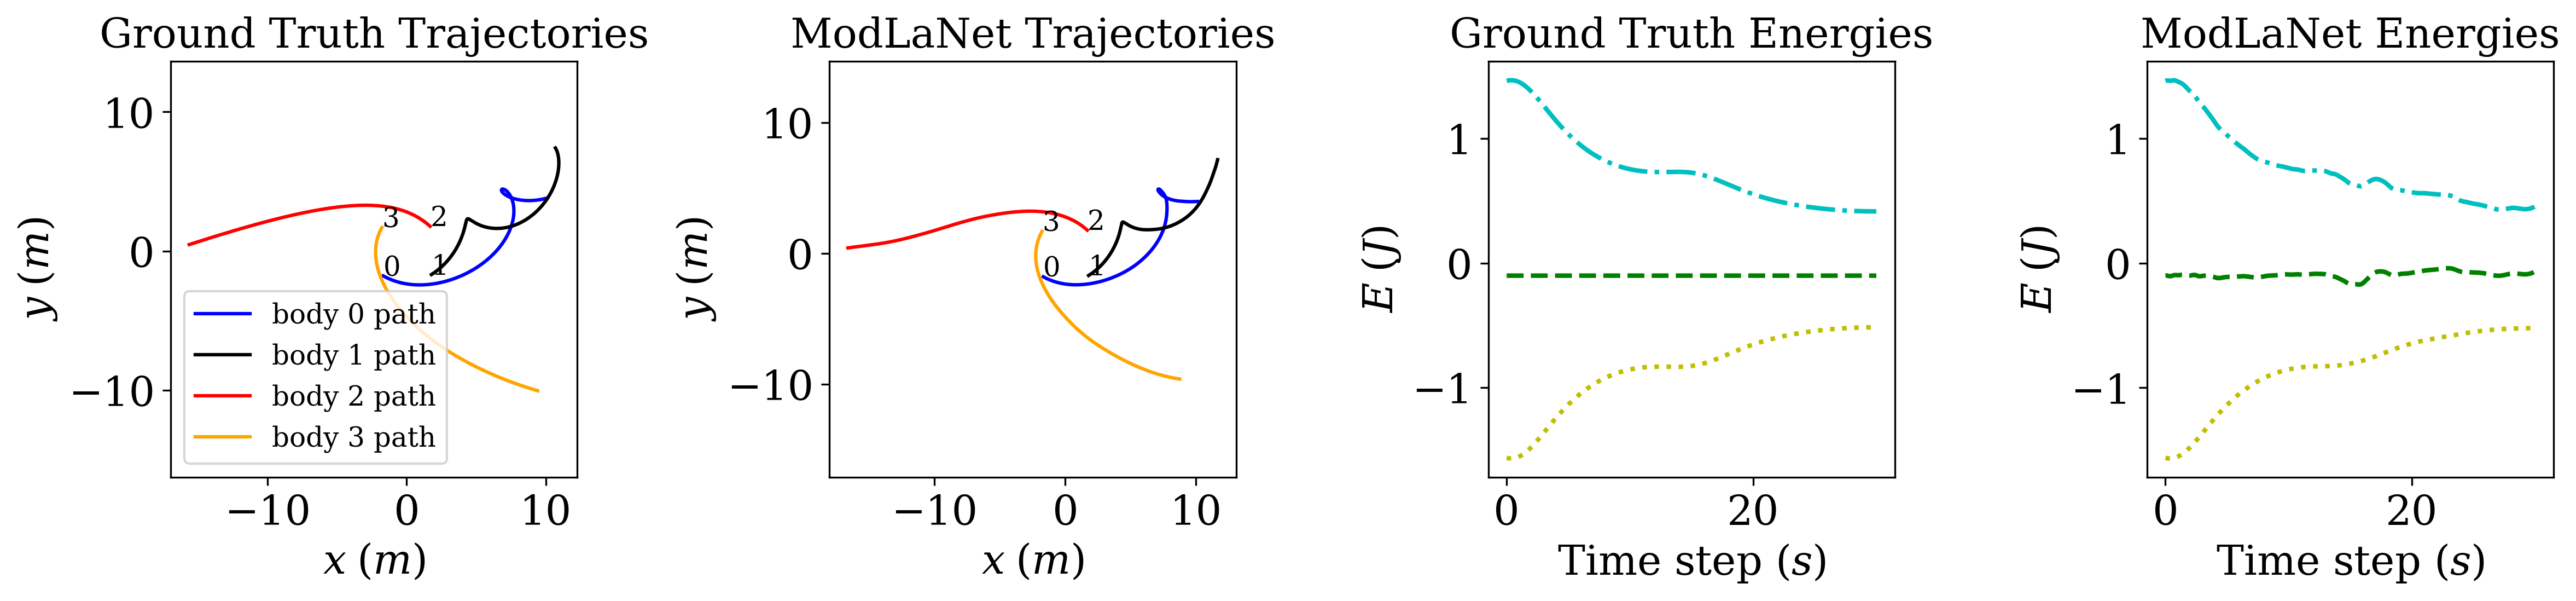

In [12]:
fig = plt.figure(figsize=(16, 4), dpi=DPI)

wordsize = 12
x, v, ac, t, E = tra1
coords = np.concatenate([x.T, v.T], axis = 0)
T, U = ds.lagrangian_kinetic(coords), ds.lagrangian_potential(coords)
colors = ['b', 'k', 'r', 'orange', 'violet', 'lime']

plt.subplot(141)
plt.title('Ground Truth Trajectories')
for i in range(args.obj):
    plt.text(x[0, i*2], x[0, i*2+1], '{}'.format(i), fontsize=12)
    if i + 1 - CUT > 0:
        plt.plot(x[:, i*2], x[:, i*2+1], color = colors[i], label='body {} path'.format(i))
    else:
        plt.plot(x[:, i*2], x[:, i*2+1], color = colors[i], label='_nolegend_'.format(i))
        
plt.axis('equal')
plt.xlabel('$x\;(m)$') ; plt.ylabel('$y\;(m)$')
plt.legend(fontsize=wordsize, loc='lower left')
# plt.yticks(np.arange(0, 30, 10))

plt.subplot(143)
plt.title('Ground Truth Energies')
plt.xlabel('Time step $(s)$'); plt.ylabel('$E\;(J)$')
plt.plot(t, U,  'y:', label='potential', linewidth=2)
plt.plot(t, T,  'c-.', label='kinetic', linewidth=2)
plt.plot(t, E,  'g--', label='total', linewidth=2)
# plt.legend(fontsize=wordsize)

y, t = modlanet_ivp['y'], modlanet_ivp['t']
plt.subplot(142)
plt.title('ModLaNet Trajectories')
for i in range(args.obj):
    plt.text(x[0, i*2], x[0, i*2+1], '{}'.format(i), fontsize=12)
    plt.plot(y[2*i], y[2*i+1], color = colors[i], label='body {} path'.format(i))
plt.axis('equal')
plt.xlabel('$x\;(m)$') ; plt.ylabel('$y\;(m)$')
# plt.legend(fontsize=wordsize)


T, U = ds.lagrangian_kinetic(y), ds.lagrangian_potential(y)
plt.subplot(144)
plt.title('ModLaNet Energies')
plt.xlabel('Time step $(s)$'); plt.ylabel('$E\;(J)$')
plt.plot(t, U,  'y:', label='potential', linewidth=2)
plt.plot(t, T,  'c-.', label='kinetic', linewidth=2)
plt.plot(t, U+T,  'g--', label='total', linewidth=2)
# plt.legend(fontsize=wordsize)

plt.tight_layout()
fig.savefig('{}/body-3+-integration-obj-{}.{}'.format(args.result_dir,args.obj,  FORMAT), bbox_inches="tight")


## Calculate bar error over 100 trajectoies

In [ ]:
# Be careful! It will take a while.
# Uncomment the code below for checking.

print('Be careful to run it! It will take a while.')
"""
num_models = 3
start = 4
end = 7

# 3 models x 3 cases x 100 repeating times, each cell contains 100 trajectories (100 vectors).
x_list, e_list = [[[] for i in range(end-start)] for i in range(num_models)], \
    [[[] for i in range(end-start)] for i in range(num_models)]

# i: 100 repeating times
# j: 3 models
# k: 3 cases
for k in range(start, end):
    args.obj = k
    modlanet_model.update(obj = args.obj)
    modlanet_model_retrain = get_model(args, model_name = 'modlanet', hidden_dim = 50, load_obj = args.obj, end_epoch = 4000, noise = 0., learn_rate = 0.001)
    modlanet_model_retrain.update(obj = args.obj)
    
    for i in range(100):
        print(k, i)
        np.random.seed(i)
        ds = Dataset(args.obj, m= [1. for _ in range(args.obj)])
        y0 = ds.random_config()
        timescale = 20
        end_time = 10
        t_span = [0, end_time]
        kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], end_time*timescale+1), 'rtol': 1e-12}

        truth_ivp = ds.get_trajectory(t_span = t_span, y0=y0, timescale = timescale, system='modlanet')
        x, v, _, _, E = truth_ivp
        coords = np.concatenate([x.T, v.T], axis = 0)
        T, U = ds.lagrangian_kinetic(coords), ds.lagrangian_potential(coords)
        j = 0
        x_list[j][k-start].append(x.T)
        e_list[j][k-start].append(U+T)

        modlanet_ivp = integrate_model(args, modlanet_model, t_span, y0, model_name = 'modlanet', **kwargs)
        y = modlanet_ivp['y']
        x = modlanet_ivp['y'][:args.obj*2]
        T, U = ds.lagrangian_kinetic(y), ds.lagrangian_potential(y)
        j = 1
        x_list[j][k-start].append(x)
        e_list[j][k-start].append(U+T)
        
        modlanet_retrain_ivp = integrate_model(args, modlanet_model_retrain, t_span, y0, model_name = 'modlanet', **kwargs)
        y = modlanet_retrain_ivp['y']
        x = modlanet_retrain_ivp['y'][:args.obj*2]
        T, U = ds.lagrangian_kinetic(y), ds.lagrangian_potential(y)
        j = 2
        x_list[j][k-start].append(x)
        e_list[j][k-start].append(U+T)

np.save('{}/analysis-body-3+.npy'.format(args.result_dir), {'x_list':np.array(x_list, dtype=object), 'e_list':np.array(e_list, dtype=object)})
"""

Be careful to run it! It will take a while.
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
4 41
4 42
4 43
4 44
4 45
4 46
4 47
4 48
4 49
4 50
4 51
4 52
4 53
4 54
4 55
4 56
4 57
4 58
4 59
4 60
4 61
4 62
4 63
4 64
4 65
4 66
4 67
4 68
4 69
4 70
4 71
4 72
4 73
4 74
4 75
4 76
4 77
4 78
4 79
4 80
4 81
4 82
4 83
4 84
4 85
4 86
4 87
4 88
4 89
4 90
4 91
4 92
4 93
4 94
4 95
4 96
4 97
4 98
4 99
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 30
5 31
5 32
5 33
5 34
5 35
5 36
5 37
5 38
5 39
5 40
5 41
5 42
5 43
5 44
5 45
5 46
5 47
5 48
5 49
5 50
5 51
5 52
5 53
5 54
5 55
5 56
5 57
5 58
5 59
5 60
5 61
5 62
5 63
5 64
5 65
5 66
5 67
5 68
5 69
5 70
5 71
5 72
5 73
5 74
5 75
5 76
5 77
5 78
5 79
5 80
5 81
5 82
5 83
5 84
5 85
5 86
5 87
5 88
5 89
5 90
5 91
5 92
5 93
5 94
5

In [5]:
results = np.load('{}/analysis-body-3+.npy'.format(args.result_dir), allow_pickle=True).item()
x_list, e_list = results['x_list'], results['e_list']
timescale = 20
end_time = 10
t_span = [0, end_time]

In [6]:
num_models = 3
start = 4
end = 7

# 2 kinds of errors x 2 models x 3 cases x 100 errors
errors = np.zeros((2, num_models-1, end-start, 100), dtype = np.float32)

# 2 kinds of errors x 2 models x 3 cases
bar_data = np.zeros((2,2,3), dtype=np.float32)
bar_error = np.zeros((2,2,3), dtype=np.float32)

# The lengths of all trajectories are the same
length = len(e_list[0][0][0]) 

# i: 100 repeating times
# j: 2 models compared with the ground truth
# k: 3 cases
# m: 2 kinds of errors
for k in range(end-start):
    j = 0; m = 0
    print('Mean error and std of modlanet without retraining when simulating {}-body system.'.format(k+start))
    for i in range(100):
        errors[m][j][k][i] = (np.linalg.norm(x_list[0][k][i]-x_list[1][k][i])/length)
    bar_data[m][j][k] = np.mean(errors[m][j][k])
    bar_error[m][j][k] = np.std(errors[m][j][k])
    print('Mean error and std of position: {:.5f} +/- {:.5f}'.format(bar_data[m][j][k], bar_error[m][j][k]))

    j = 0; m = 1
    for i in range(100):
        errors[m][j][k][i] = (np.linalg.norm(e_list[0][k][i]-e_list[1][k][i])/length)
    bar_data[m][j][k] = np.mean(errors[m][j][k])
    bar_error[m][j][k] = np.std(errors[m][j][k])
    print('Mean error and std of total energy: {:.5f} +/- {:.5f}'.format(bar_data[m][j][k], bar_error[m][j][k]))

    print('')    
    
    j = 1; m = 0
    print('Mean error and std of modlanet after retraining when simulating {}-body system.'.format(k+start))
    for i in range(100):
        errors[m][j][k][i] = (np.linalg.norm(x_list[0][k][i]-x_list[2][k][i])/length)
    bar_data[m][j][k] = np.mean(errors[m][j][k])
    bar_error[m][j][k] = np.std(errors[m][j][k])
    print('Mean error and std of position: {:.5f} +/- {:.5f}'.format(bar_data[m][j][k], bar_error[m][j][k]))

    j = 1; m = 1
    for i in range(100):
        errors[m][j][k][i] = (np.linalg.norm(e_list[0][k][i]-e_list[2][k][i])/length)
    bar_data[m][j][k] = np.mean(errors[m][j][k])
    bar_error[m][j][k] = np.std(errors[m][j][k])
    print('Mean error and std of total energy: {:.5f} +/- {:.5f}'.format(bar_data[m][j][k], bar_error[m][j][k]))

    print('')

Mean error and std of modlanet without retraining when simulating 4-body system.
Mean error and std of position: 0.01267 +/- 0.01431
Mean error and std of total energy: 0.00128 +/- 0.00302

Mean error and std of modlanet after retraining when simulating 4-body system.
Mean error and std of position: 0.00929 +/- 0.01358
Mean error and std of total energy: 0.00081 +/- 0.00157

Mean error and std of modlanet without retraining when simulating 5-body system.
Mean error and std of position: 0.02832 +/- 0.02897
Mean error and std of total energy: 0.00238 +/- 0.00266

Mean error and std of modlanet after retraining when simulating 5-body system.
Mean error and std of position: 0.01942 +/- 0.02253
Mean error and std of total energy: 0.00220 +/- 0.00405

Mean error and std of modlanet without retraining when simulating 6-body system.
Mean error and std of position: 0.05907 +/- 0.05714
Mean error and std of total energy: 0.00582 +/- 0.01336

Mean error and std of modlanet after retraining when s

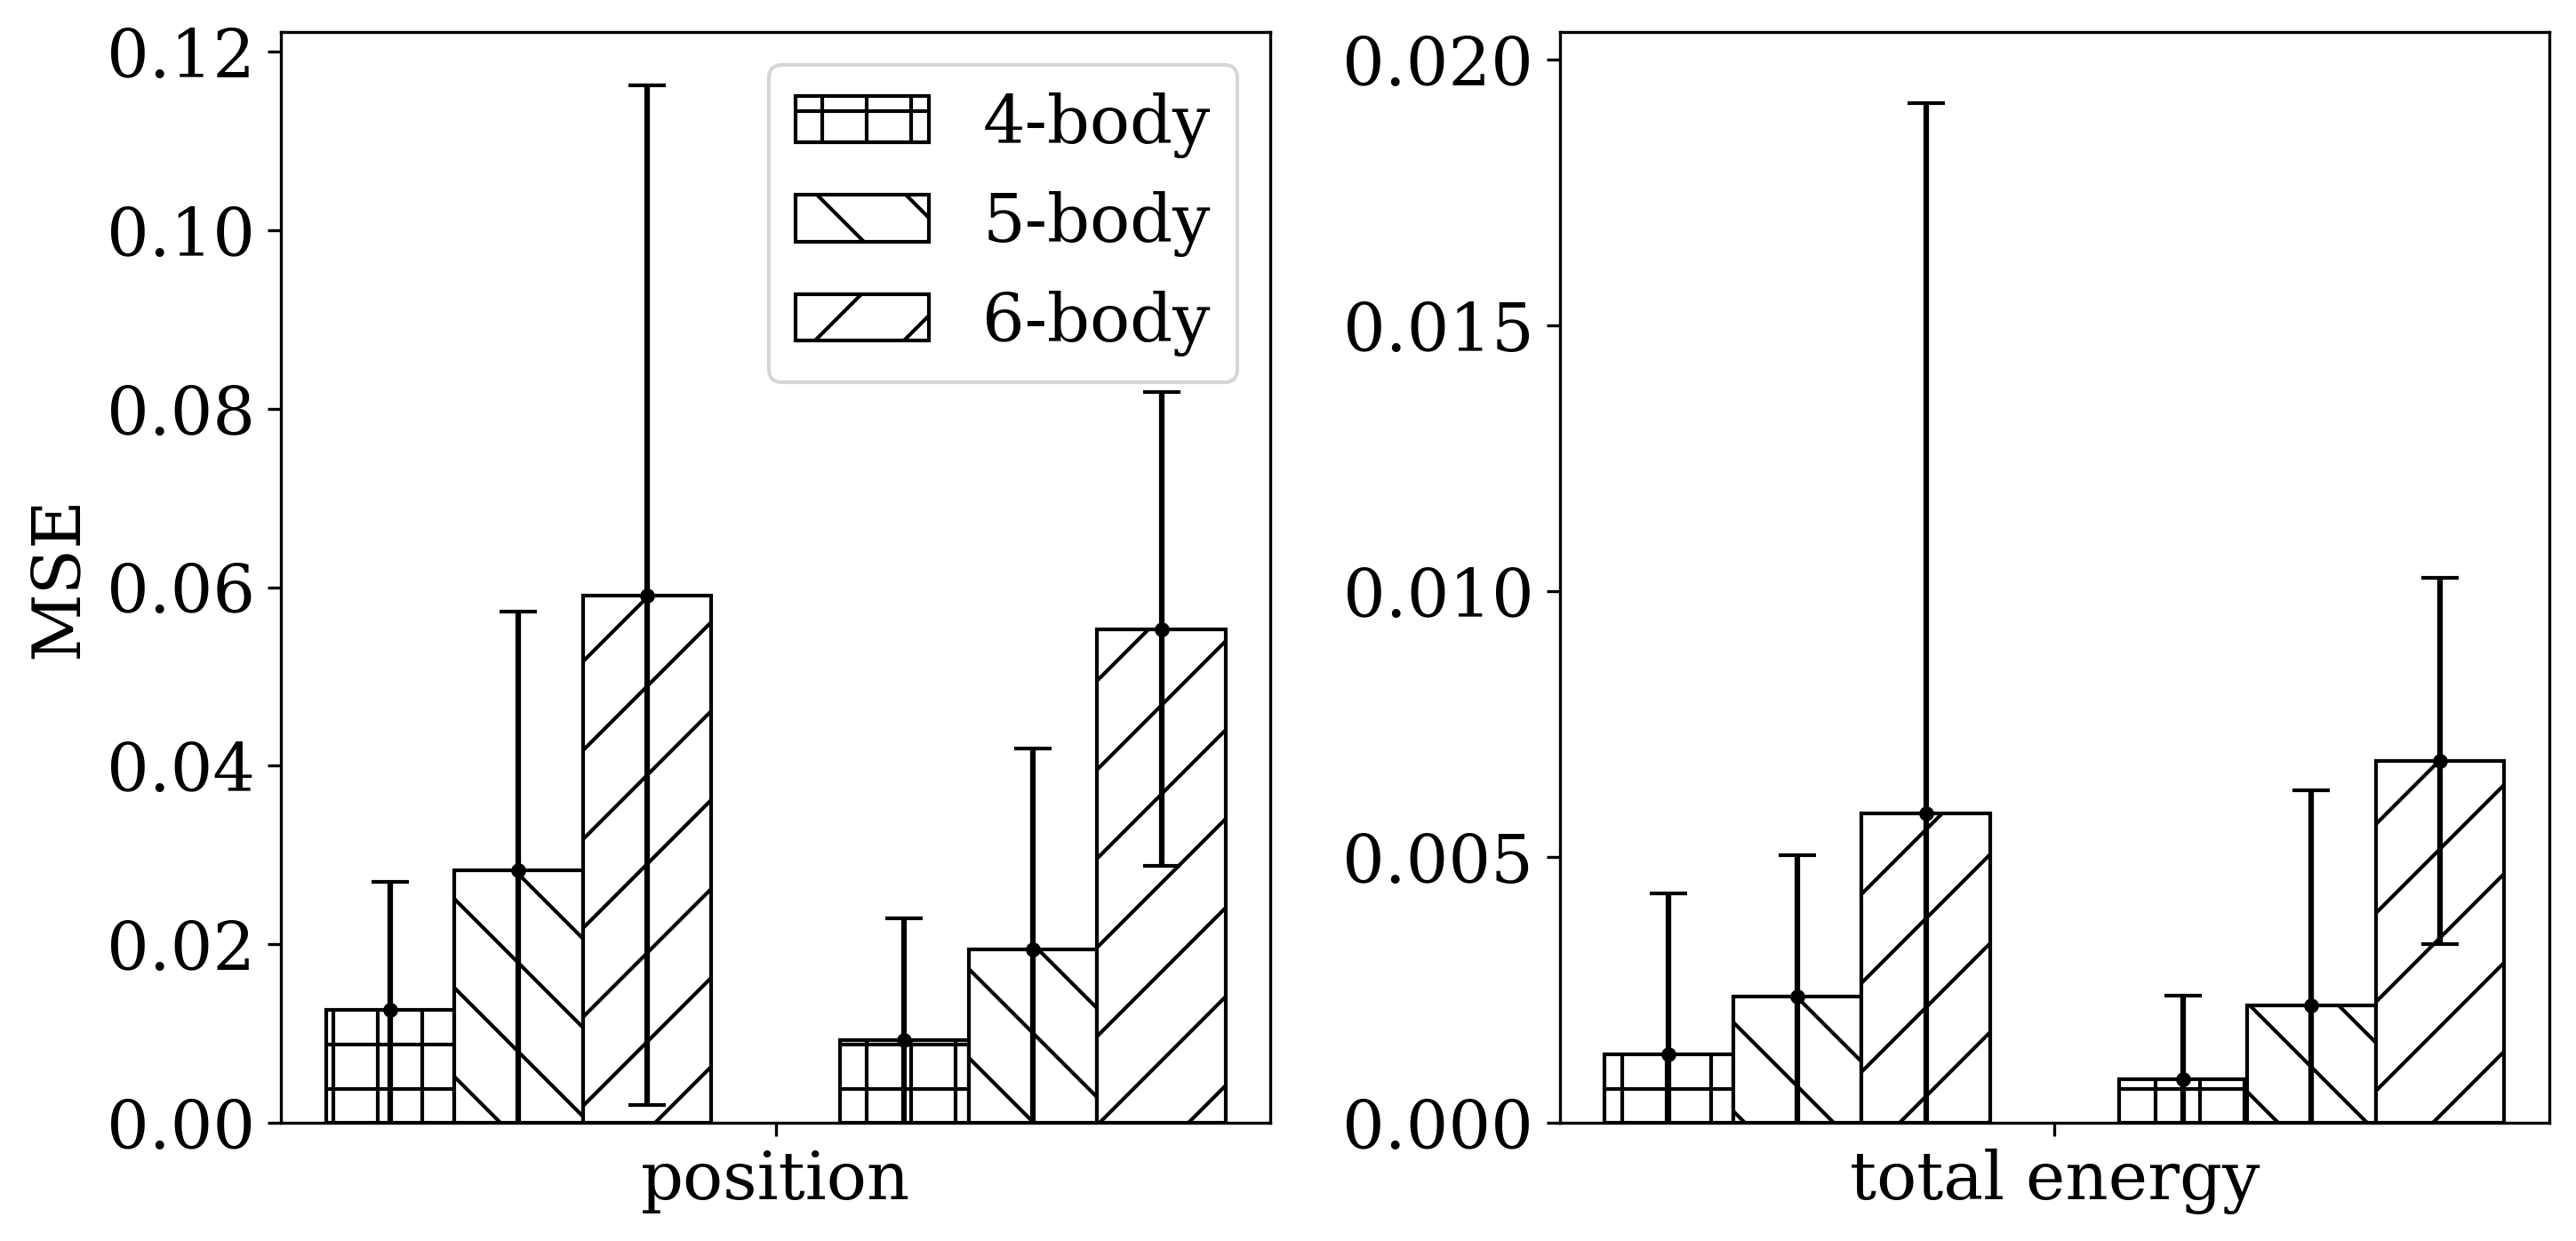

In [7]:
# Ref: 
# https://matplotlib.org/stable/gallery/scales/log_bar.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html

data_labels = ['{}-body'.format(i) for i in range(start, end)]

x_labels = [['position'], ['total energy'],]
y_labels = [['MSE']]
patterns = [ "+", "\\", "/", ".", "-", "|" ,"x", "*",  "o", "O" ]

x = np.arange(len(x_labels[0]))*1
# x = np.arange(len(labels))  # the label locations
width = 0.05# the width of the bars

fig = plt.figure(figsize = [10, 5], dpi=DPI)
rects = []
for j in range(len(x_labels)):
    ax = plt.subplot(1, 2, j+1)
    for k in range(1):
        for i in range(0, len(data_labels)):
            rect = ax.bar(x - ((len(data_labels)-1)/2-i)*width - 2*width, bar_data[j:j+1, k, i], width, label=data_labels[i], color='white', edgecolor='black', hatch=patterns[i])
            rects.append(rect)
            plt.errorbar(x - ((len(data_labels)-1)/2-i)*width - 2*width, bar_data[j:j+1, k, i], yerr=bar_error[j:j+1, k, i], fmt='.k', capsize=5, capthick=1, label='__none__');
    for k in range(1, 2):
        for i in range(0, len(data_labels)):
            rect = ax.bar(x - ((len(data_labels)-1)/2-i)*width + 2*width, bar_data[j:j+1, k, i], width, label='__none__', color='white', edgecolor='black', hatch=patterns[i])
            rects.append(rect)
            plt.errorbar(x - ((len(data_labels)-1)/2-i)*width + 2*width, bar_data[j:j+1, k, i], yerr=bar_error[j:j+1, k, i], fmt='.k', capsize=5, capthick=1, label='__none__');
       
    # Add some text for labels, title and custom x-axis tick labels, etc.
    if j == 0:
        ax.legend()
        ax.set_ylabel('MSE')
        ax.set_ylim(bottom = 0)
    if j == 1:
        ax.set_ylim(bottom = 0)
    # ax.set_yscale('log')
    # ax.set_title('Number of threads')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels[j])
    
    # ax.set_title('data size: {}'.format(title_labels[j]))
fig.tight_layout()

plt.show()
fig.savefig('{}/body-3+-100traj.png'.format(args.result_dir))
